######Installations here

In [ ]:
!pip install django
# !pip install googletrans==3.1.0a0
!pip install sentencepiece
!pip install numpy==1.16.1
!pip install fairseq
!pip install cython

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

####imports here

In [ ]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import urllib3
import django.utils.encoding
from django.utils import http
# from googletrans import Translator
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import nltk
nltk.download('words')
from nltk.corpus import words
englishwords = set(words.words())
from numpy import array
from numpy import asarray
from numpy import zeros
import warnings
from keras.models import Sequential
from keras.initializers import Constant
from keras import layers
from keras.layers import Bidirectional, LSTM
from keras.optimizers import Adam
import keras
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from google.colab import files
import fairseq
from nltk.corpus import words
from bs4 import BeautifulSoup
import nltk, string, re, spacy,unicodedata, random
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import ToktokTokenizer
import nltk, string, re, spacy,unicodedata, random

%matplotlib inline

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/TASME/data/tamil_offensive_full_train.csv', names=['text','label','nan'])
train = train.drop(columns=['nan'])
train = train.dropna()
train.label = train.label.apply({'Not_offensive':0,'Offensive_Untargetede':1,'Offensive_Targeted_Insult_Group':2,'Offensive_Targeted_Insult_Individual':3,'not-Tamil':4, 'Offensive_Targeted_Insult_Other':5}.get)
train

,text,label
0,movie vara level la Erika poguthu,0
1,I love Ajith Kumar Vivegam movie inki mjy bht ...,4
2,Padam nalla comedy padama irukum polaye..,0
3,karthick subburaj anne .... intha padam vetri ...,0
4,கவுண்டர் தேவர்.சார்பாக வெற்றி பெற வாழ்த்துக்கள் 🦁,0
...,...,...
35134,Trending number #2 idhukku nammalam karanamnu ...,0
35135,"Movie script super, athuvum HIP HOP Tamizha mu...",0
35136,Just 3k likes for 300k likes,0
35137,Aaloo le lo. Kanda le lo.,4


In [ ]:
val = pd.read_csv('/content/drive/MyDrive/TASME/data/tamil_offensive_full_dev.csv', names=['text','label','nan'])
val = val.drop(columns=['nan'])
val = val.dropna()
val.label = val.label.apply({'Not_offensive':0,'Offensive_Untargetede':1,'Offensive_Targeted_Insult_Group':2,'Offensive_Targeted_Insult_Individual':3,'not-Tamil':4, 'Offensive_Targeted_Insult_Other':5}.get)
val

,text,label
0,Handsome hunk keri vaa thalaivaa,0
1,தென்காசி மாவட்டம் நாடார் சமுதாயம் சார்பாக வாழ்...,0
2,je vous aime bravo pour clip de merde que j éc...,4
3,சிறப்பு..... மேலும் இது போன்ற படைப்புகள் மிக அ...,0
4,Vera level BGM .. semma trailer. 🤞,0
...,...,...
4383,மிஷ்கின் - சினிமாவின் சலித்து போன வட்டத்திற்க...,0
4384,Sivaji - Bhajii Sapdu Petta - Sweet Sapdu Ser...,0
4385,8k dislike sure all vijay fans,5
4386,Lady super star Manju warrier Fans Hit like,0


In [ ]:
test = pd.read_csv('/content/drive/MyDrive/TASME/data/tamil_offensive_full_test_with_labels.csv', names=['text', 'label'])
test.label = test.label.apply({'Not_offensive':0,'Offensive_Untargetede':1,'Offensive_Targeted_Insult_Group':2,'Offensive_Targeted_Insult_Individual':3,'not-Tamil':4, 'Offensive_Targeted_Insult_Other':5}.get)
test = test.dropna()
test

,text,label
0,14.12.2018 epo trailer pathutu irken ... Semay...,0
1,Paka thana poro movie la Enna irukunu,0
2,“U kena tunggu lebih lama lagi untuk tahu saya...,4
3,Suriya anna vera level anna mass,0
4,suma kaththaatha da sound over a pooda kudaath...,1
...,...,...
4387,மண்ணு பொண்ணு ரெண்டுமே ஒன்னு அதுல எவன் கைய வச்ச...,2
4388,Babu mele ko ye song sunke kuch yesa feel hua ...,4
4389,asuran= aadukalam+pudupettai+ wada chennai..ye...,0
4390,Vijay's all movies look like same.,0


####Exploratory Analysis

In [ ]:
def findMaxLen(df):
  maxlen=0
  for i in range(len(df['text'])):
    if(len(df['text'][i].split())>maxlen):
      maxlen = len(df['text'][i].split())
      maxind=i
  return maxlen,maxind

print(findMaxLen(train))
print(findMaxLen(val))
print(findMaxLen(test))

#####Pre-process



In [ ]:
def deEmojify(string):
  emoji_pattern = re.compile("["
                              u"\U0001F600-\U0001F64F"  # emoticons
                              u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                              u"\U0001F680-\U0001F6FF"  # transport & map symbols
                              u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                              u"\U00002500-\U00002BEF"  # chinese char
                              u"\U00002702-\U000027B0"
                              u"\U00002702-\U000027B0"
                              u"\U000024C2-\U0001F251"
                              u"\U0001f926-\U0001f937"
                              u"\U00010000-\U0010ffff"
                              u"\u2640-\u2642"
                              u"\u2600-\u2B55"
                              u"\u200d"
                              u"\u23cf"
                              u"\u23e9"
                              u"\u231a"
                              u"\ufe0f"  # dingbats
                              u"\u3030"
                              "]+", flags=re.UNICODE)
  return emoji_pattern.sub(r'', string)

def preprocess(text):
  text = deEmojify(text) #convert emojis to their defns in words, they might be useful
  text = re.sub(r'([\.\'\"\/\-\_\--])',' ', text) # remove punctuations , removes @USER / some abbreviatins
  to_remove_url = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
      '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
  text = re.sub(to_remove_url,'',text)  # remove url patterns
  text = re.sub(" \d+", " ", text)
  text = text.replace(","," ")
  text = re.sub(r'(?:^| )\w(?:$| )', ' ', text).strip()
  punctuation='!!"$%&()*+-/:;<=>?[\\]^_{|}~.'
  text = ''.join(ch for ch in text if ch not in set(punctuation))
  # text = text.translate(str.maketrans('', '', string.punctuation))
  text = BeautifulSoup(text, 'html.parser').get_text()
    # Stopword Removing
  tokenizer = ToktokTokenizer()
  # convert sentence into token of words
  tokens = tokenizer.tokenize(text)
  tokens = [token.strip() for token in tokens]
  text = ' '.join(ch for ch in tokens)
  return text 

def clean(df):
  df['text'] = df['text'].apply(lambda x: preprocess(x))

clean(train)
clean(val)
clean(test)

###Tokenizer

In [ ]:
max_features = 2000
max_len = 512
tokenizer = Tokenizer(num_words=max_features, split=' ')

In [ ]:
tokenizer.fit_on_texts(train['text'].values)
X_train = tokenizer.texts_to_sequences(train['text'].values)
# vocab_size = len(tokenizer.word_index) + 1
X_train = pad_sequences(X_train,padding = 'post', maxlen=max_len)

In [ ]:
tokenizer.fit_on_texts(val['text'].values)
X_val = tokenizer.texts_to_sequences(val['text'].values)
# vocab_size = len(tokenizer.word_index) + 1
X_val = pad_sequences(X_val,padding = 'post', maxlen=max_len)

In [ ]:
tokenizer.fit_on_texts(test['text'].values)
X_test = tokenizer.texts_to_sequences(test['text'].values)
# vocab_size = len(tokenizer.word_index) + 1
X_test = pad_sequences(X_test,padding = 'post', maxlen=max_len)

###GloVe Embeddings

In [ ]:
def get_and_save_glove_embeddings(max_features,save_as_path): 
  global num_words
  !wget --header="Host: nlp.stanford.edu" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/69.0.3497.100 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8" --header="Accept-Language: en-US,en;q=0.9" --header="Cookie: _ga=GA1.2.456156586.1539718115; _gid=GA1.2.491677602.1539718115; _gat=1" --header="Connection: keep-alive" "https://nlp.stanford.edu/data/glove.6B.zip" -O "glove.6B.zip" -c
  !unzip glove.6B.zip

  embeddings_index = dict()

  glove_file = open('glove.6B.100d.txt', encoding="utf8")

  for line in glove_file:
      records = line.split()
      word = records[0]
      vector_dimensions = asarray(records[1:], dtype='float32')
      embeddings_index[word] = vector_dimensions
  glove_file.close()

  print('Found %s word vectors.' %len(embeddings_index))

  word_index = tokenizer.word_index
  print(len(word_index))


  num_words = min(max_features, len(word_index)) + 1
  print(num_words)

  embedding_dim = 100

  embedding_matrix = np.zeros((num_words, embedding_dim))

  for word, i in word_index.items():
      if i > max_features:
          continue
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          embedding_matrix[i] = embedding_vector
      else:
          embedding_matrix[i] = np.random.randn(embedding_dim)

  np.save(save_as_path,embedding_matrix)

get_and_save_glove_embeddings(max_features,save_as_path='/content/drive/MyDrive/Journal Paper - Offensive/models/cnn_bilstm/embeddings/tanglish_tamil_script_official_train_glove_embeds1.npy')   

--2021-07-16 16:27:45--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-07-16 16:27:45--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.08MB/s    in 2m 40s  

2021-07-16 16:30:26 (5.13 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: 

###Load Embeddings

In [ ]:
d = np.load('/content/drive/MyDrive/Journal Paper - Offensive/models/cnn_bilstm/embeddings/tanglish_tamil_script_official_train_glove_embeds1.npy')
d.shape

(2001, 100)

###Model

In [ ]:
embed_dim = 100

model = Sequential()
model.add(layers.Embedding(num_words, embed_dim, embeddings_initializer=Constant(d), input_length=max_len))
model.add(Bidirectional(LSTM(10, return_sequences=True)))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(6, activation='softmax'))
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 512, 100)          200100    
_________________________________________________________________
bidirectional (Bidirectional (None, 512, 20)           8880      
_________________________________________________________________
conv1d (Conv1D)              (None, 508, 128)          12928     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 6)                 7

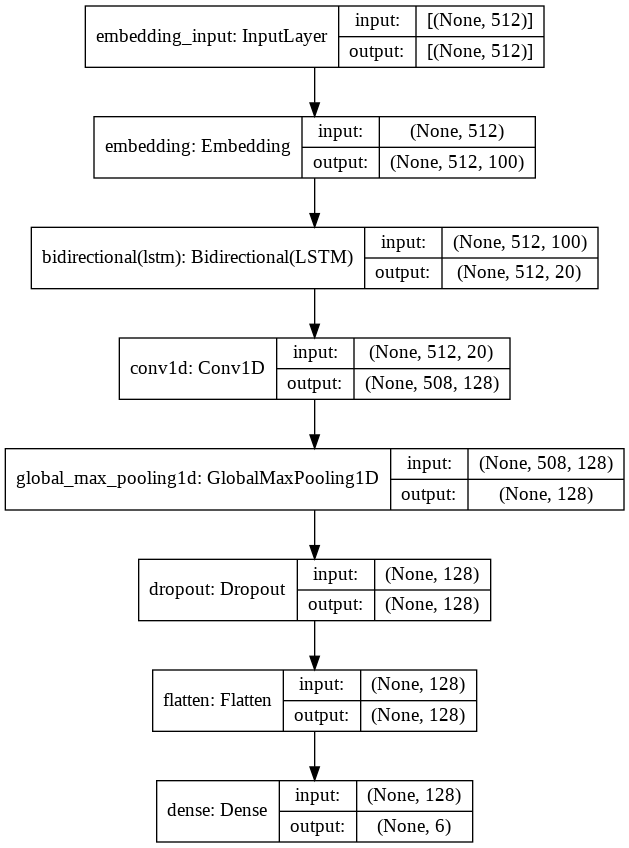

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='/content/drive/MyDrive/TASME/model_plot.png', show_shapes=True, show_layer_names=True)

###Trainning & Predictions

In [ ]:
optimizer = Adam(
    learning_rate=0.01,
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

model.compile(loss = keras.losses.kullback_leibler_divergence, optimizer=optimizer,metrics = ['accuracy'])

In [ ]:
y_train = train['label']
y_val = val['label']

In [ ]:
Y_train=pd.get_dummies(y_train).values
Y_val = pd.get_dummies(y_val).values

print(Y_train)

[[1 0 0 0 0 0]
 [0 0 0 0 1 0]
 [1 0 0 0 0 0]
 ...
 [1 0 0 0 0 0]
 [0 0 0 0 1 0]
 [1 0 0 0 0 0]]


In [ ]:
history = model.fit(X_train, Y_train,batch_size = 64, validation_data=(X_val,Y_val), epochs=10, verbose=2)
model.save("/content/drive/MyDrive/TASME/model/cnn_bilstm.h5")

Epoch 1/10
550/550 - 74s - loss: 0.8018 - accuracy: 0.7442 - val_loss: 1.0272 - val_accuracy: 0.7083
Epoch 2/10
550/550 - 22s - loss: 0.6754 - accuracy: 0.7707 - val_loss: 1.1086 - val_accuracy: 0.7035
Epoch 3/10
550/550 - 22s - loss: 0.6313 - accuracy: 0.7827 - val_loss: 1.1403 - val_accuracy: 0.6839
Epoch 4/10
550/550 - 22s - loss: 0.6077 - accuracy: 0.7901 - val_loss: 1.1729 - val_accuracy: 0.6864
Epoch 5/10
550/550 - 22s - loss: 0.5893 - accuracy: 0.7964 - val_loss: 1.1867 - val_accuracy: 0.6730
Epoch 6/10
550/550 - 22s - loss: 0.5764 - accuracy: 0.8013 - val_loss: 1.2162 - val_accuracy: 0.6782
Epoch 7/10
550/550 - 22s - loss: 0.5630 - accuracy: 0.8054 - val_loss: 1.2465 - val_accuracy: 0.6746
Epoch 8/10
550/550 - 22s - loss: 0.5531 - accuracy: 0.8095 - val_loss: 1.2509 - val_accuracy: 0.6753
Epoch 9/10
550/550 - 22s - loss: 0.5444 - accuracy: 0.8122 - val_loss: 1.2707 - val_accuracy: 0.6675
Epoch 10/10
550/550 - 22s - loss: 0.5379 - accuracy: 0.8143 - val_loss: 1.2881 - val_accura

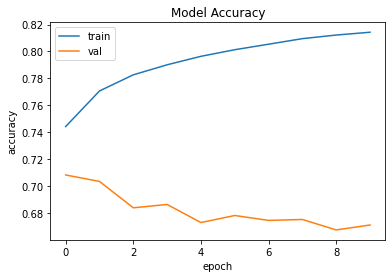

In [ ]:
plt.plot(history.history['accuracy']) 
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'])
#plt.show()
plt.savefig('Model_accuracy.png', dpi=600)

In [ ]:
import tensorflow as tf
model = tf.keras.models.load_model('/content/drive/MyDrive/TASME/model/cnn_bilstm.h5')

In [ ]:
# score = model.evaluate(X_val,Y_val,verbose=1)
predictions = np.argmax(model.predict(X_val),axis = -1)

# print("Test score is {}".format(score[0]))
# print("Test Accuracy is {}".format(score[1]))

In [ ]:
_, train_acc = model.evaluate(X_train, Y_train, verbose=0)
_, val_acc = model.evaluate(X_val, Y_val, verbose=0)

In [ ]:
print(val_acc)
print(train_acc)

0.6711485981941223
0.822647213935852


###Evaluate

In [ ]:
rounded_predictions = np.argmax(model.predict(X_test, batch_size=128, verbose=0),axis = -1)

In [ ]:
rounded_labels=np.argmax(Y_val, axis=1)

In [ ]:
print(classification_report(rounded_labels, predictions))

              precision    recall  f1-score   support

           0       0.74      0.90      0.81      3193
           1       0.13      0.05      0.07       356
           2       0.18      0.09      0.12       295
           3       0.15      0.07      0.10       307
           4       0.04      0.01      0.02       172
           5       0.00      0.00      0.00        65

    accuracy                           0.67      4388
   macro avg       0.21      0.19      0.19      4388
weighted avg       0.57      0.67      0.61      4388



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(rounded_predictions)

[0 0 0 ... 0 0 0]


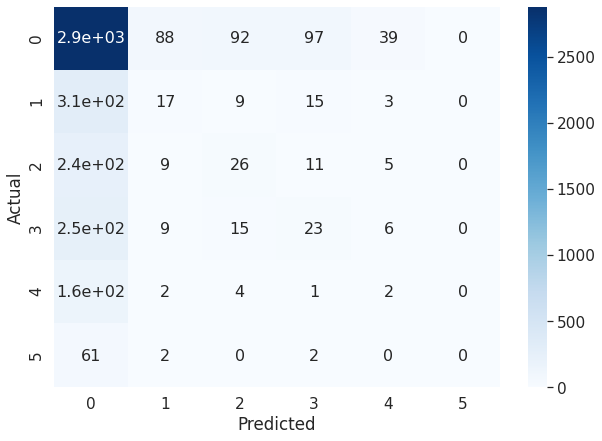

In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np



data = confusion_matrix(rounded_labels,predictions)
df_cm = pd.DataFrame(data, columns=np.unique(rounded_labels), index = np.unique(rounded_labels))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size